In [475]:
import numpy as np
import matplotlib.pyplot as plt

###Activation Functions

In [476]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
  return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
  return np.where(np.asarray(x) > 0, x, 0)

def d_relu(x):
    return np.where(x <= 0, 0, 1)

def softmax(x):
    e_x = np.exp(x)
    return e_x/e_x.sum()

###Cost Function:

In [477]:
def cross_entropy_loss(y, y_hat, i):
  return -np.log(y_hat[y[i]][0])

In [478]:
def cost(y, y_hat, i):
  
  m = y.shape[0]
  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))
  c = np.squeeze(c) 

  return c

###Layer Class : parameters initialization for each layer

In [479]:
class Layer:

    activationFunc = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'relu' : (relu, d_relu),
        'softmax' : (softmax, None)
    }

    def __init__(self, inputs, neurons, activation):
        self.W = np.random.randn(neurons, inputs)
        self.b = np.zeros((neurons, 1))
        self.act, self.d_act = self.activationFunc.get(activation)

### Forward propagation

In [480]:
def forward_propagation(h, layers):
  m = len(layers)
  
  layers[0].a = np.dot(layers[0].W, h)
  layers[0].h = layers[0].act(layers[0].a)
  
  for j in range(1, m-1):
    layers[j].a = np.dot(layers[j].W, layers[j-1].h)
    layers[j].h = layers[j].act(layers[j].a)

  j+=1
  layers[j].a = np.dot(layers[j].W, layers[j-1].h)
  layers[j].h = softmax(layers[j].a)

  return layers[m-1].h

###Backward_propagation

In [481]:
def backward_propagation(l, y_hat, layers, inp):
  
  #one-hot vector
  e_l = np.zeros((y_hat.shape[0], 1))
  e_l[l] = 1
  
  layers[len(layers)-1].da = -(e_l - y_hat)                 #gradient w.r.t activation of last layer (a_L)
  
  for j in range(len(layers)-1, 0, -1):
    layers[j].dW = np.dot(layers[j].da, (layers[j-1].h).T)
    layers[j].db = layers[j].da

    layers[j-1].dh = np.dot((layers[j].W).T, layers[j].da)
    layers[j-1].da = np.multiply(layers[j-1].dh, layers[j-1].d_act(layers[j-1].a))

  layers[0].dW = np.dot(layers[j].da, inp.T)
  layers[0].db = layers[j].da

###Gradient Descent

In [482]:
def gradient_decent(learning_rate, layers):

  for layer in layers:
    layer.W = layer.W - learning_rate * layer.dW
    layer.b = layer.b - learning_rate * layer.db

###Putting all togather:

####Train Model

In [483]:
def model_train(epochs, learning_rate, x_train, y_train, activation, h_layers, neurons):

  #epochs = 5
  m = x_train.shape[0]
  #learning_rate = 0.001

  layers= [Layer(x_train.shape[1], neurons, activation)]

  for _ in range(0, h_layers):
    layers.append(Layer(neurons, neurons, activation))
  layers.append(Layer(neurons, 10, 'softmax'))
  
  #layers = [Layer(x_train.shape[1], 32), Layer(32, 32), Layer(32, 32), Layer(32, 32), Layer(32, 10)]
  costs = []

  for epoch in range(epochs):

    cost = 0

    # Feedforward
    for i in range(m):
      
      h = x_train[i].reshape(784, 1)

      h = forward_propagation(h, layers)

      # Calulate cost to plot graph
      cost += cross_entropy_loss(y_train, h, i)

      # Backpropagation
      backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

      #stocastic gradient decent
      gradient_decent(learning_rate, layers)

    costs.append(cost/m)
  
  return layers, costs

###Import dataset and putting in appropriate format

In [484]:
from keras.datasets import fashion_mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

In [485]:
print("x_train shape: ", x_train_org.shape)
print("y_train shape: ", y_train_org.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


In [486]:
x_train = x_train_org.reshape(x_train_org.shape[0], -1)
y_train = y_train_org

In [487]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print((x_train[0].reshape(784, 1)).shape)

x_train shape:  (60000, 784)
y_train shape:  (60000,)
(784, 1)


###Train Model

In [488]:
epochs = 5
learning_rate = 0.001
activation = 'sigmoid'
h_layers = 3
neurons = 32

layers, costs = model_train(epochs, learning_rate, x_train, y_train, activation, h_layers, 32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [489]:
# Making predictions
h = forward_propagation(x_train.T, layers)
print(h)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[[1.40749048e-09 3.70379903e-06 6.76991139e-07 ... 5.55507330e-07
  4.80076847e-06 6.27471636e-09]
 [6.09572372e-09 6.51614374e-08 2.04854473e-06 ... 3.52676442e-06
  1.78839802e-07 3.27158748e-09]
 [1.49474625e-07 9.83771313e-07 8.78853827e-09 ... 2.93615647e-09
  2.60189392e-07 4.87658277e-08]
 ...
 [1.61177051e-07 7.12830265e-10 9.12983979e-09 ... 2.01943782e-08
  6.35876959e-10 1.90734920e-06]
 [4.35895921e-07 5.22827931e-09 1.35510013e-08 ... 1.16620747e-08
  3.76355059e-09 6.77015457e-07]
 [3.54828887e-06 3.09482144e-10 1.86327449e-09 ... 2.76060823e-09
  4.03499144e-10 1.96835132e-06]]


[1.5629064727949133, 1.059344302072048, 1.0531694281552768, 0.9662718382313937, 0.9436280133298889]


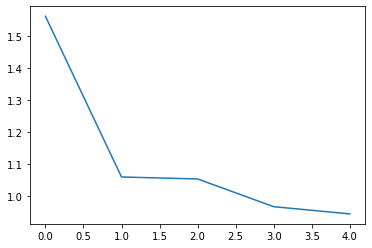

In [490]:
plt.plot(range(epochs), costs)
print(costs)